# Exploratory Data Analysis

This notebook is intended for:
- Development of data pipelines
- Data visualisation
- Basic analysis of trends in the data

**Data sources:**
- Elexon BMRS API
    - [Documentation page](https://bmrs.elexon.co.uk/api-documentation/introduction)
- UK Met Office:
    - [Hourly weather data](https://catalogue.ceda.ac.uk/uuid/99173f6a802147aeba430d96d2bb3099/)
    - [Hourly solar radiation data](https://catalogue.ceda.ac.uk/uuid/76e54f87291c4cd98c793e37524dc98e/)

In [1]:
# Import required dependencies
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use('seaborn-v0_8-colorblind')

## Glossary

**Fuel types:**

- COAL 
- OIL 
- GAS, including
    - CCGT: Combined cycle gas turbine
    - OCGT: Open cycle gas turbine
- WIND 
- SOLAR
- NPSHYD: Non-pumped storage hydropower
- NUCLEAR
- BIOMASS
- PS: Pumped storage
- INTER:  Imports/exports from/to other grids via interconnectors
- OTHER

**Data sets:**
- AGPT: Actual generation data per settlement period aggregrated by power system resource type
- FUELHH: Half-hourly generation outturn aggregrated by fuel type

## 2. Data from BMRS API

In [2]:
# Load metadata from BMRS API documentation (https://bmrs.elexon.co.uk/api-documentation/introduction)
with open('API-metadata-2025-09-28T08_10_52.072Z.json') as f:
    metadata = json.load(f)

if type(metadata) is list:
    if all([di is None for di in metadata[1:]]):
        metadata = metadata[0]
    else:
        raise Warning("Unexpected data structure.")
    
print('Data keys:\n', metadata.keys())

Data keys:
 dict_keys(['openapi', 'info', 'servers', 'paths', 'components', 'tags'])


### 2.1 Half-hourly electricity generation data

In this section, we collect from two BMRS datasets, 'AGPT' and 'FUELHH', to get an accurate breakdown of the different energy sources.

In [3]:
# note: maximum date range is 4 days
params = {
    "publishDateTimeFrom": "2025-02-01 00:00",
    "publishDateTimeTo": "2025-02-04 01:00",
    "format": "json"
}

In [4]:
# Get generation data for each settlement perioid from AGPT
# This dataset does not include flows from interconnects
url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/AGPT/"

response = requests.get(url, params=params)

if response.ok:
    AGPT_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [5]:
# Unpack AGPT data into a dataframe
df = pd.DataFrame(AGPT_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_AGPT = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    columns='psrType', 
    values='quantity',
    aggfunc='first'
).reset_index()

# Sort by settlement date and period
df_AGPT = df_AGPT.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# group onshore and offshore wind
df_AGPT['WIND'] = df_AGPT[['Wind Offshore', 'Wind Onshore']].sum(axis=1)
df_AGPT = df_AGPT.drop(columns=['Wind Offshore', 'Wind Onshore'])

# group hydro and other 
df_AGPT['OTHER'] = df_AGPT[['Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Other']].sum(axis=1)
df_AGPT = df_AGPT.drop(columns=['Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Other'])

# rename remaining columns
df_AGPT = df_AGPT.rename(columns={
    "Nuclear": "NUCLEAR",
    "Biomass": "BIOMASS",
    "Fossil Gas": "GAS",
    "Fossil Oil": "OIL",
    "Fossil Hard coal": "COAL",
    "Solar": "SOLAR"  
    })

# these should be the final generation types
gen_types_AGPT = {'NUCLEAR', 'BIOMASS', 'GAS', 'OIL', 'COAL', 'WIND', 'SOLAR', 'OTHER'}
cols = set(df_AGPT.columns) - {'startTime', 'settlementDate', 'settlementPeriod'}
assert cols == set(gen_types_AGPT)

df_AGPT

psrType,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER
0,2025-01-31,47,2025-01-31 23:00:00+00:00,2212.0,15908.0,0.0,0.0,4273.0,0.0,3184.279,578.0
1,2025-01-31,48,2025-01-31 23:30:00+00:00,2444.0,13168.0,0.0,0.0,4269.0,0.0,3521.178,671.0
2,2025-02-01,1,2025-02-01 00:00:00+00:00,2521.0,12067.0,0.0,0.0,4263.0,0.0,4125.956,677.0
3,2025-02-01,2,2025-02-01 00:30:00+00:00,2557.0,11594.0,0.0,0.0,4276.0,0.0,4552.016,648.0
4,2025-02-01,3,2025-02-01 01:00:00+00:00,2550.0,11316.0,0.0,0.0,4266.0,0.0,5109.811,713.0
...,...,...,...,...,...,...,...,...,...,...,...
141,2025-02-03,44,2025-02-03 21:30:00+00:00,3199.0,12135.0,0.0,0.0,4288.0,0.0,15843.282,1569.0
142,2025-02-03,45,2025-02-03 22:00:00+00:00,3181.0,9820.0,0.0,0.0,4286.0,0.0,16246.008,1144.0
143,2025-02-03,46,2025-02-03 22:30:00+00:00,3191.0,7311.0,0.0,0.0,4289.0,0.0,16329.424,787.0
144,2025-02-03,47,2025-02-03 23:00:00+00:00,3172.0,5493.0,0.0,0.0,4289.0,0.0,16026.528,818.0


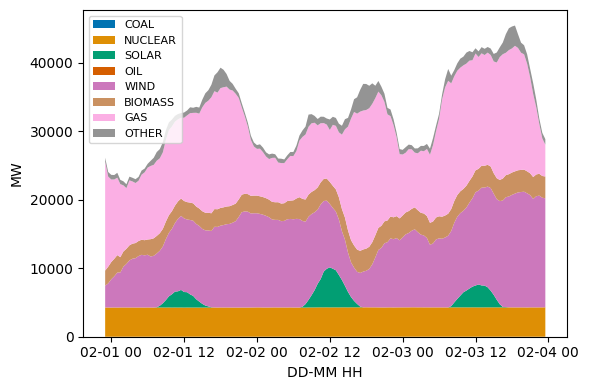

In [6]:
# Plot AGPT breakdown
colors = sns.color_palette("colorblind", len(gen_types_AGPT))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.stackplot(df_AGPT['startTime'], [df_AGPT[gt] for gt in gen_types_AGPT], labels=gen_types_AGPT, colors=colors)
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

In [7]:
# Get interconnect data from the FUELHH dataset
url = "https://data.elexon.co.uk/bmrs/api/v1/datasets/FUELHH/"

response = requests.get(url, params=params)

if response.ok:
    FUELHH_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [8]:
# Unpack FUELHH data into a dataframe
df = pd.DataFrame(FUELHH_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_FUELHH = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    columns='fuelType', 
    values='generation',
    aggfunc='first'
).reset_index()

# Sort by settlement date and period
df_FUELHH = df_FUELHH.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Simplify FUELHH dataframe by grouping categories:
# group gas categories
df_FUELHH['GAS'] = df_FUELHH[['OCGT', 'CCGT']].sum(axis=1)
df_FUELHH = df_FUELHH.drop(columns=['OCGT', 'CCGT'])

# group interconnectors
interconnects = df_FUELHH.filter(regex='^INT')
total_interconnect = interconnects.sum(axis=1)
df_FUELHH = df_FUELHH.filter(regex='^(?!INT)')
df_FUELHH['INTER'] = total_interconnect

# group pumped storage, non-pumped hydro and other
df_FUELHH['OTHER'] = df_FUELHH[['OTHER', 'PS', 'NPSHYD']].sum(axis=1)
df_FUELHH = df_FUELHH.drop(columns=['PS', 'NPSHYD'])

# these should be are the final generation types
gen_types_FUELHH = {'NUCLEAR', 'BIOMASS', 'GAS', 'OIL', 'COAL', 'WIND', 'INTER', 'OTHER'}
cols = set(df_FUELHH.columns) - {'startTime', 'settlementDate', 'settlementPeriod'}
assert cols == gen_types_FUELHH

# display
df_FUELHH

fuelType,settlementDate,settlementPeriod,startTime,BIOMASS,COAL,NUCLEAR,OIL,OTHER,WIND,GAS,INTER
0,2025-01-31,48,2025-01-31 23:30:00+00:00,2501,0,4275,0,650,2986,12650,5036
1,2025-02-01,1,2025-02-01 00:00:00+00:00,2553,0,4268,0,634,3504,11818,5414
2,2025-02-01,2,2025-02-01 00:30:00+00:00,2566,0,4270,0,675,3931,11354,5582
3,2025-02-01,3,2025-02-01 01:00:00+00:00,2418,0,4273,0,629,4441,11104,5000
4,2025-02-01,4,2025-02-01 01:30:00+00:00,2223,0,4275,0,589,4838,10192,5164
...,...,...,...,...,...,...,...,...,...,...,...
142,2025-02-03,46,2025-02-03 22:30:00+00:00,3191,0,4289,0,817,12601,6528,290
143,2025-02-03,47,2025-02-03 23:00:00+00:00,3183,0,4295,0,781,12273,5084,756
144,2025-02-03,48,2025-02-03 23:30:00+00:00,3192,0,4291,0,497,12190,4575,692
145,2025-02-04,1,2025-02-04 00:00:00+00:00,2915,0,4298,0,103,12209,4603,1008


Align the time stamps and create full generation dataset by combining interconnect data from FUELHH with AGPT data

In [9]:
# Define settlement date range
start_date = '2025-02-01'
end_date = '2025-02-03'

# Filter by settlement date and period range
df_AGPT_filtered = df_AGPT[
    (df_AGPT['settlementDate'] >= start_date) & 
    (df_AGPT['settlementDate'] <= end_date)
].copy()

df_FUELHH_filtered = df_FUELHH[
    (df_FUELHH['settlementDate'] >= start_date) & 
    (df_FUELHH['settlementDate'] <= end_date)
].copy()

# Merge generation datasets on settlementDate and settlementPeriod
df_generation = df_AGPT_filtered.merge(
    df_FUELHH_filtered[['settlementDate', 'settlementPeriod', 'INTER']], 
    on=['settlementDate', 'settlementPeriod'],
    how='inner'
)

generation_types = gen_types_AGPT.union(gen_types_FUELHH)

df_generation

,settlementDate,settlementPeriod,startTime,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,INTER
0,2025-02-01,1,2025-02-01 00:00:00+00:00,2521.0,12067.0,0.0,0.0,4263.0,0.0,4125.956,677.0,5414
1,2025-02-01,2,2025-02-01 00:30:00+00:00,2557.0,11594.0,0.0,0.0,4276.0,0.0,4552.016,648.0,5582
2,2025-02-01,3,2025-02-01 01:00:00+00:00,2550.0,11316.0,0.0,0.0,4266.0,0.0,5109.811,713.0,5000
3,2025-02-01,4,2025-02-01 01:30:00+00:00,2237.0,10676.0,0.0,0.0,4277.0,0.0,5109.811,619.0,5164
4,2025-02-01,5,2025-02-01 02:00:00+00:00,2219.0,9671.0,0.0,0.0,4278.0,0.0,5956.036,593.0,5050
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2025-02-03,44,2025-02-03 21:30:00+00:00,3199.0,12135.0,0.0,0.0,4288.0,0.0,15843.282,1569.0,-1384
140,2025-02-03,45,2025-02-03 22:00:00+00:00,3181.0,9820.0,0.0,0.0,4286.0,0.0,16246.008,1144.0,168
141,2025-02-03,46,2025-02-03 22:30:00+00:00,3191.0,7311.0,0.0,0.0,4289.0,0.0,16329.424,787.0,290
142,2025-02-03,47,2025-02-03 23:00:00+00:00,3172.0,5493.0,0.0,0.0,4289.0,0.0,16026.528,818.0,756


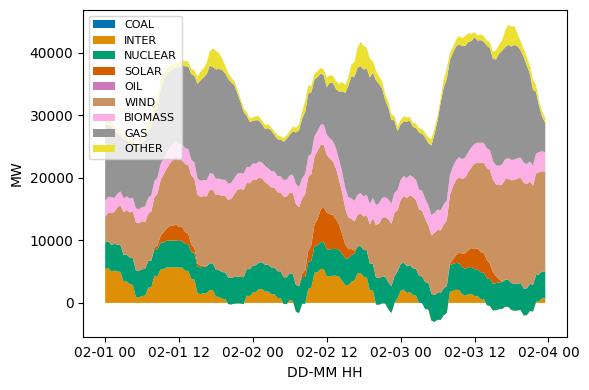

In [10]:
# Plot full breakdown
colors = sns.color_palette("colorblind", len(generation_types))
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.stackplot(df_generation['startTime'], [df_generation[gt] for gt in generation_types], labels=generation_types, colors=colors)
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

When more electricity is exported than imported, the interconnect values are negative which explains the previous plot going below zero for some times.

### 2.2 Initial national demand outturn (INDO)

The INDO measures the half-hourly averaged demand metered by the transmission company in MW. 

- INDO: Takes into account transmission losses but does not include station transformer load, pumped storage demand or interconnector demand.
- ITSDO (initial Transmission System Demand outturn): Takes into account transmission losses, station transformer load, pumped storage demand and interconnector demand.

In [11]:
# Make call to API
url = "https://data.elexon.co.uk/bmrs/api/v1/demand/outturn"

# note: maximum date range is 4 days
params = {
    "settlementDateFrom": "2025-02-01",
    "settlementDateTo": "2025-02-03",
    "settlementPeriod": np.arange(1, 50),
    "format": "json"
}

response = requests.get(url, params=params)

if response.ok:
    demand_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [12]:
# Unpack data into a dataframe
df = pd.DataFrame(demand_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_demand = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    values=['initialDemandOutturn','initialTransmissionSystemDemandOutturn']
).reset_index()

# Sort by settlement date and period
df_demand = df_demand.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Filter by settlement date range
df_demand = df_demand[
    (df_demand['settlementDate'] >= start_date) & 
    (df_demand['settlementDate'] <= end_date)
]

df_demand = df_demand.rename(columns={
    "initialDemandOutturn": "INDO",
    "initialTransmissionSystemDemandOutturn": "ITSO"
    })

df_demand

,settlementDate,settlementPeriod,startTime,INDO,ITSO
0,2025-02-01,1,2025-02-01 00:00:00+00:00,27162.0,27972.0
1,2025-02-01,2,2025-02-01 00:30:00+00:00,27508.0,28145.0
2,2025-02-01,3,2025-02-01 01:00:00+00:00,27020.0,27637.0
3,2025-02-01,4,2025-02-01 01:30:00+00:00,26324.0,26945.0
4,2025-02-01,5,2025-02-01 02:00:00+00:00,25563.0,26247.0
...,...,...,...,...,...
139,2025-02-03,44,2025-02-03 21:30:00+00:00,30486.0,34476.0
140,2025-02-03,45,2025-02-03 22:00:00+00:00,28787.0,31816.0
141,2025-02-03,46,2025-02-03 22:30:00+00:00,26792.0,29774.0
142,2025-02-03,47,2025-02-03 23:00:00+00:00,25154.0,27677.0


Plot demand with the generation data:

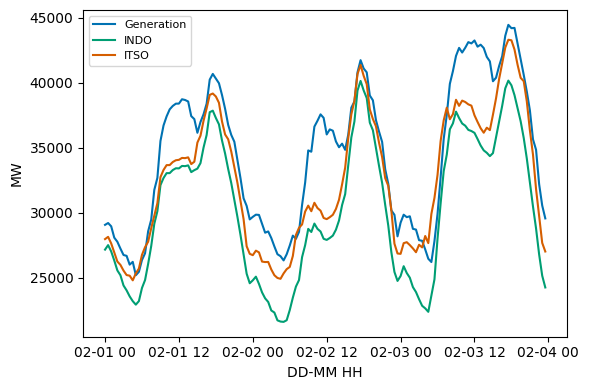

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), layout='tight')
ax.plot(df_generation['startTime'], df_generation[list(generation_types)].sum(axis=1), label='Generation')
ax.plot(df_demand['startTime'], df_demand['INDO'], label='INDO')
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='ITSO')
ax.legend(fontsize=8)
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)
plt.show()

### 2.3 Get market price index data:

In [14]:
# Make call to API
url = "https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index"

# note: maximum date range is 4 days
params = {
    "from": "2025-02-01 00:00",
    "to": "2025-02-04 00:00",
    "dataProviders": ["APX"],
    "format": "json"
}

response = requests.get(url, params=params)

if response.ok:
    price_data = response.json()  # parse JSON
else:
    print("Error:", response.status_code, response.text)

In [15]:
# Unpack data into a dataframe
df = pd.DataFrame(price_data['data'])
df['startTime'] = pd.to_datetime(df['startTime'])

# Create pivot table with multi-level columns
df_price = df.pivot_table(
    index=['settlementDate', 'settlementPeriod', 'startTime'], 
    values=['price', 'volume']
).reset_index()

# Sort by settlement date and period
df_price = df_price.sort_values(['settlementDate', 'settlementPeriod']).reset_index(drop=True)

# Filter by settlement date range
df_price = df_price[
    (df_price['settlementDate'] >= start_date) & 
    (df_price['settlementDate'] <= end_date)
]

df_price

,settlementDate,settlementPeriod,startTime,price,volume
0,2025-02-01,1,2025-02-01 00:00:00+00:00,116.34,907.45
1,2025-02-01,2,2025-02-01 00:30:00+00:00,116.17,1051.50
2,2025-02-01,3,2025-02-01 01:00:00+00:00,109.65,1338.20
3,2025-02-01,4,2025-02-01 01:30:00+00:00,102.70,1241.55
4,2025-02-01,5,2025-02-01 02:00:00+00:00,100.13,1035.00
...,...,...,...,...,...
139,2025-02-03,44,2025-02-03 21:30:00+00:00,113.07,3455.60
140,2025-02-03,45,2025-02-03 22:00:00+00:00,109.88,2906.80
141,2025-02-03,46,2025-02-03 22:30:00+00:00,106.76,3267.55
142,2025-02-03,47,2025-02-03 23:00:00+00:00,96.13,1790.30


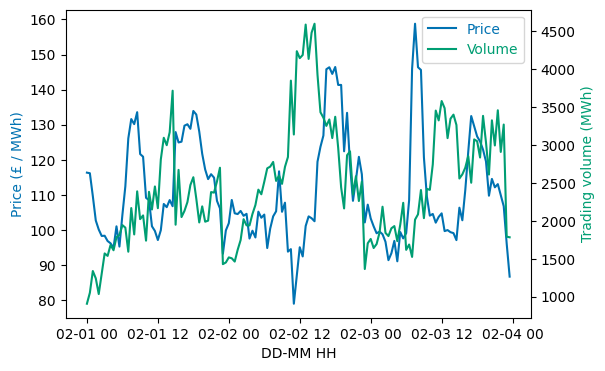

In [16]:
# Plot price and trading volume on twin axes
from mpl_toolkits.axes_grid1 import host_subplot

plt.figure(figsize=(6,4))
host = host_subplot(111)
par = host.twinx()

host.set_xlabel("DD-MM HH", fontsize=10)
host.set_ylabel("Price (£ / MWh)", fontsize=10)
par.set_ylabel("Trading volume (MWh)", fontsize=10)

p1, = host.plot(df_price['startTime'], df_price['price'], label="Price")
p2, = par.plot(df_price['startTime'], df_price['volume'], label="Volume")

host.legend(labelcolor="linecolor")

host.yaxis.label.set_color(p1.get_color())
par.yaxis.label.set_color(p2.get_color())

plt.show()

Plot price with demand and generation data:

In [17]:
df_demand['ITSO']

0      27972.0
1      28145.0
2      27637.0
3      26945.0
4      26247.0
        ...   
139    34476.0
140    31816.0
141    29774.0
142    27677.0
143    27017.0
Name: ITSO, Length: 144, dtype: float64

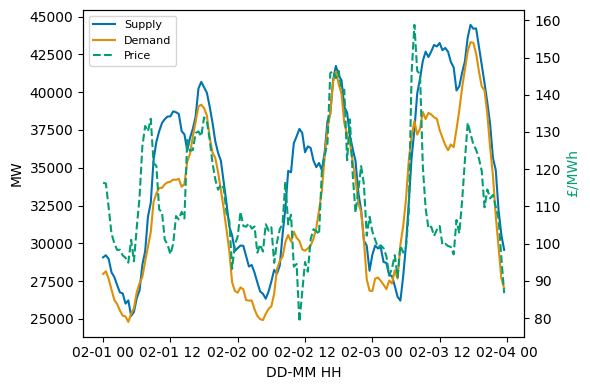

In [ ]:
total_generation = df_generation[list(generation_types)].sum(axis=1)

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

colors = sns.color_palette("colorblind", 3)

# Left axis - Power
ax.plot(df_generation['startTime'], total_generation, label='Supply', color=colors[0])
ax.plot(df_demand['startTime'], df_demand['ITSO'], label='Demand', color=colors[1])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10)

# Right axis - Price
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'], label='Price', linestyle='--', color=colors[2])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[2])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)

plt.show()

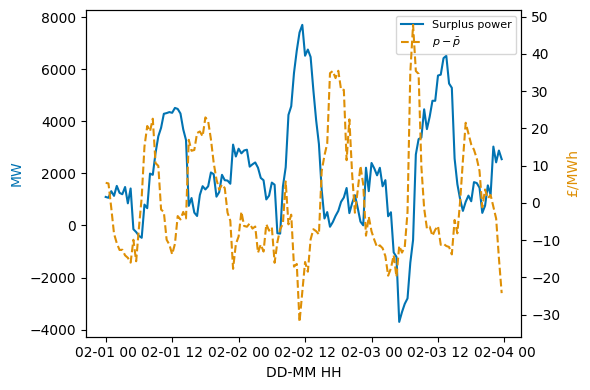

In [ ]:
surplus = total_generation - df_demand['ITSO']
mean_price = np.mean(df_price['price'])

fig, ax = plt.subplots(figsize=(6, 4), layout='tight')

# plot power surplus, i.e. energy generation - energy demand
ax.plot(df_generation['startTime'], surplus, label='Surplus power', color=colors[0])
ax.set_xlabel('DD-MM HH', fontsize=10)
ax.set_ylabel('MW', fontsize=10, color=colors[0])
ax.legend(fontsize=8)

# plot price fluctuation from mean
ax2 = ax.twinx()
ax2.plot(df_price['startTime'], df_price['price'] - mean_price, label='$p - \\bar{p}$', linestyle='--', color=colors[1])
ax2.set_ylabel('£/MWh', fontsize=10, color=colors[1])

# Combine legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8)
plt.show()

- For generated power larger than the demand for power, 'surplus power' is positive.
- For generated power smaller than the demand for power, 'surplus power' is negative.

In the previous plot, we see that prices are much higher than the mean when surplus power is large and negative, while prices are low when surplus power is large and positive. When supply approximately matches demand, the price lies near the mean. Qualitatively, these observations match what you would expect to see in a market where price is driven by supply and demand.

## 3. Data from Met Office API

Let's get some weather from the Met Office which will be key to building models that can accurately forecast electricity prices.